In [4]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### redshift_to_snap(redshift)
Simple function which converts a redshift into the corresponing snapshot name to easily construct the path to the halo

**Parameters**:
- **redshift**: Redshift you want to convert (has to be 6,8 or 10)

**Returns**:
- **snapname**: Name of the snapshot the **redshift** corresponds to

In [2]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

### get_paths(halo_id, conf, redshift)
Constructs the path to the output of the simulation as well as to the density map

**Parameters**:
- **halo_id**: ID of the halo to which you want to determine the path
- **conf**: Configuration of the simulation e.g. 'fid2' 
- **redshift**: Redshift of the halo you want to examine

**Returns**:
- **simulation_path**: Path to the output maps of the simulation
- **density_path**: Path to the density used in the simulation

In [3]:
def get_paths(halo_id, conf, redshift):
    snap = redshift_to_snap(redshift)
    conf_dir = os.path.join('/ptmp/mpa/mglatzle/TNG_f_esc', conf)
    simulation_path =  os.path.join(conf_dir, f'run/L35n2160TNG/{snap}/g{halo_id}/Output/phys_ic00_rt05.out')
    dens_path =  os.path.join(conf_dir, f'run/L35n2160TNG/{snap}/g{halo_id}/Input/dens_ic00.in')
    return simulation_path, dens_path

### get_H_map(halo)
Simple function to calculate a map for xHI from xHII
**Parameters**:
- **halo**: Output of a simulation which should not be manipulated to ensure the map with index 1 is the HII map

**Returns**:
- **xHI**: Map containing the distribution of xHI

In [4]:
def get_H_map(halo):
    return np.ones(halo[1].shape)-halo[1]

### get_He_map(halo)
Simple function to calculate a map for xHeI from xHeII and xHeII
**Parameters**:
- **halo**: Output of a simulation which should not be manipulated to ensure the map with index 2 and 3 are the HeII and HeII maps respectively

**Returns**:
- **xHeI**: Map containing the distribution of xHeI

In [5]:
def get_He_map(halo):
    return np.ones(halo[1].shape)-halo[2]-halo[3]

### get_slice(cube, axis)
Function which cuts out a slice from the center of the map along a given axis
**Parameters**:
- **cube**: Simulation map
- **axis**: Axis along which you want to slice the halo

**Returns**:
- **map_slice**: Slice through the center of the map

In [6]:
def get_slice(cube, axis, method = 'slice', density = None):
    center = cube.shape[0]//2
    if method == 'slice':
        if axis == 0:
            map_slice = cube[center,...]
        elif axis == 1:
            map_slice = cube[:, center, :]
        elif axis == 2:
            map_slice = cube[:,:,center]
        else:
            raise ValueError('Axis number out of bounds')
    else:
        map_slice = get_projection(cube, axis=axis, method=method, density=density)
    return map_slice

In [7]:
def get_projection(cube, axis, method, density):
    if method == 'line_average':
        map_slice = np.sum(cube, axis=axis)/cube.shape[0]
    elif method == 'density_average':
        dens_weighted = cube*density
        map_slice = np.sum(dens_weighted, axis=axis)/np.sum(density, axis=axis)
    elif method == 'test':
        dens_weighted = cube*density
        map_slice_dens = np.sum(dens_weighted, axis=axis)/np.sum(density, axis=axis)
        map_slice_lin = np.sum(cube, axis=axis)/cube.shape[0]
        map_slice = map_slice_lin-map_slice_dens
    else:
        error_message = f'Method {method} is not implemented'
        raise NotImplementedError(error_message)
    return map_slice

### print_data(maps)
Returns statistical information about the maps being examined

**Parameters**:
- **maps**: Dictionary of maps for which the statistical information is returned

In [8]:
def print_data(maps):
    for i, key in enumerate(maps):
        if i == 0:
            print(f'This halo has the shape {maps[key].shape}.')
            print('*'*85)
            
        maxi = np.max(maps[key])
        mini = np.min(maps[key])
        average = np.average(maps[key])
        median = np.median(maps[key])
        print(f'''For {key} the max value is {maxi:.2f}, the min value is {mini:.2f}
        , the average is {average:.2f} and the median is {median:.2f}.''')
        print('*'*85)
    return

### get_maps(halo_id, conf, redshift, props, get_data=False)
Returns the density, temperature and ionization maps of a halo

**Parameters**:
- **halo_id**: ID of the halo to which you want to determine the path
- **conf**: Configuration of the simulation e.g. 'fid2' 
- **redshift**: Redshift of the halo you want to examine
- **props**: Properties for which you want to obtain the maps
- **get_data**: Should a statistical summary of the maps be printed out (default: False)


**Returns**:
- **maps**: Dictionary containing **props** as keys and the corresponding maps as values

In [9]:
def get_maps(halo_id, conf, redshift, props, get_data=False):
    prop_dict = {'T':0, 'xHII':1, 'xHeII':2, 'xHeIII':3}
    sim_path, dens_path = get_paths(halo_id, conf, redshift) 
    halo = crashMemMap(sim_path, 'all')
    dens = crashMemMap(dens_path, 'all')
    
    maps = {}
    for prop in props:
        if prop in prop_dict:
            maps[prop] = halo[prop_dict[prop]]
        elif prop == 'xHI':
            maps[prop] = get_H_map(halo)
        elif prop == 'xHeI':
            maps[prop] = get_He_map(halo)
        elif prop == 'dens':
            maps[prop] = dens[0]
        else:
            raise ValueError(f'The property {prop} does not exist.')
    
    if get_data:
        print_data(maps)
        
    return maps

### plot_maps(halo_id, conf, redshift, props, axis=0)
Plots slices of the maps of props 

**Parameters**:
- **halo_id**: ID of the halo to which you want to determine the path
- **conf**: Configuration of the simulation e.g. 'fid2' 
- **redshift**: Redshift of the halo you want to examine
- **props**: Properties for which you want to obtain the maps
- **axis**: Axis along which you want to slice the halo


In [10]:
def get_grid_radius(r, r_v, side_length):
    grid_r = r*side_length/(2*r_v)
    return grid_r

In [65]:
def get_row_compressor(old_dimension, new_dimension):
    dim_compressor = np.zeros((new_dimension, old_dimension))
    bin_size = float(old_dimension) / new_dimension
    next_bin_break = bin_size
    which_row = 0
    which_column = 0
    while which_row < dim_compressor.shape[0] and which_column < dim_compressor.shape[1]:
        if round(next_bin_break - which_column, 10) >= 1:
            dim_compressor[which_row, which_column] = 1
            which_column += 1
        elif next_bin_break == which_column:

            which_row += 1
            next_bin_break += bin_size
        else:
            partial_credit = next_bin_break - which_column
            dim_compressor[which_row, which_column] = partial_credit
            which_row += 1
            dim_compressor[which_row, which_column] = 1 - partial_credit
            which_column += 1
            next_bin_break += bin_size
    dim_compressor /= bin_size
    return dim_compressor


def get_column_compressor(old_dimension, new_dimension):
    return get_row_compressor(old_dimension, new_dimension).transpose()

def compress_and_average(array, new_shape):
    # Note: new shape should be smaller in both dimensions than old shape
    return np.mat(get_row_compressor(array.shape[0], new_shape[0])) * \
           np.mat(array) * \
           np.mat(get_column_compressor(array.shape[1], new_shape[1]))

def source_pos(ID, redshift, conf, side_length):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    
    coord = np.array(coord)
    lum = np.vectorize(lum_str_to_float)(lum)

    halo_cube = np.zeros((side_length,  side_length, side_length))
    for i in range(coord.shape[0]):
        pos = coord[i,:]
        try:
            halo_cube[pos[0],pos[1],pos[2]]+=lum[i][0]*1e52
        except:
            print(f'One stellar particle is at {pos}')
    return halo_cube

def project_pos(halo_cube, axis=0, size=None):
    if size == None:
        size = halo_cube.shape[0]
    if size > halo_cube.shape[0]:
        raise ValueError('Size of the projextion has to be smaller or equal to the size of the simulation cube')
    projected = np.sum(halo_cube, axis=axis)
    compressed_scaled = compress_and_average(projected, [size, size])
    compressed = compressed_scaled*(projected.shape[0]/size)**2
    return np.ma.filled(np.log10(np.ma.masked_equal(compressed, 0)), 0)

def compressed_map(ID, redshift, conf, side_lenght, size=None, axis=0):
    halo_cube = source_pos(ID, redshift, conf, side_lenght)
    source_map = project_pos(halo_cube, axis, size=size)
    return source_map

In [88]:
def plot_maps(halo_id, conf, redshift, init_props, r_v, r_m, axis=0, method='slice', 
              save=False, fesc=None, source_dens=False, source_width=None, appendix=''):
    titlesize = 40
    
    label_map = {'xHI':r'$x_\mathrm{HI}$','xHII':r'$x_\mathrm{HII}$',r'xHeI':'$x_\mathrm{HeI}$',
                 r'xHeII':'$x_\mathrm{HeII}$','xHeIII':r'$x_\mathrm{HeIII}$','T':r'$T[\mathrm{K}]$',
                 'dens':r'$\rho[\mathrm{cm}^{-3}]$'}
    all_props = ['T', 'dens', 'xHII', 'xHeII', 'xHeIII']
    props = init_props.copy()
    maps = get_maps(halo_id, conf, redshift, all_props)
    with_source_dens = int(source_dens)
    f, axarr = plt.subplots(len(props)+with_source_dens, 1)
    
    
    if source_dens:
        side_length = maps[list(maps.keys())[0]].shape[0]
        source_map = compressed_map(halo_id, redshift, conf, side_length, size=source_width, axis=axis)
        map_name = 'source_dens'
        maps[map_name] = source_map
        props.append(map_name)
        label_map['source_dens'] = r'$\log(Q_\mathrm{sources})[s^{-1}]$'
    
#     for i,key in enumerate(maps):
    for i,key in enumerate(props):
#         if i==0:
#             axarr[i].set_title(f'ID {halo_id}', size=titlesize)
        side_length = maps[key].shape[0]
        if (props[i] != 'T') and (props[i] != 'dens') and (props[i] != 'source_dens'):
            norm = Normalize(0,1)
        elif props[i] == 'source_dens':
            norm = Normalize()
        else:
            norm = LogNorm()
            
        if (props[i] != 'source_dens'):
            if props[i]=='dens':
                method_to_use = 'line_average'
            else:
                method_to_use = method
            plot_slice = get_slice(maps[key], axis, density=maps['dens'], method=method_to_use)
            subfig = axarr[i].imshow(plot_slice, extent=[0,side_length,0,side_length], norm=norm, 
                                             cmap=plt.get_cmap('inferno'))
        else:
            subfig = axarr[i].imshow(maps[key], extent=[0,maps[key].shape[0],0,maps[key].shape[0]], norm=norm, 
                                             cmap=plt.get_cmap('inferno'))
        
        
        theta=np.linspace(0,2*np.pi,50)
        r_virial = get_grid_radius(r_v,r_v, side_length)
        r_mass = get_grid_radius(r_m,r_v, side_length)
        
        vir_x=np.cos(theta)*r_virial+side_length/2
        vir_y=np.sin(theta)*r_virial+side_length/2
        
        mass_x=np.cos(theta)*r_mass+side_length/2
        mass_y=np.sin(theta)*r_mass+side_length/2

        axarr[i].plot(vir_x, vir_y, '--', linewidth=2, color='white')
        axarr[i].plot(mass_x, mass_y, '--', linewidth=2, color='green')
        axarr[i].set_yticklabels([])
        axarr[i].set_xticklabels([])
        #axarr[i].axis('off')
        #axarr[i].set_title(label_map[props[i]], size=20)
        axarr[i].set_ylabel(label_map[props[i]], size=20)
        
        divider = make_axes_locatable(axarr[i])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = f.colorbar(subfig, orientation='vertical',cax=cax)
        #cbar.set_label(label_map[props[i]], size=20)
        cbar.ax.tick_params(labelsize=10)
    if len(props)%3==1:
        f.delaxes(axarr[int(np.floor(len(props)/3)), 1])
        f.delaxes(axarr[int(np.floor(len(props)/3)), 2])
    elif len(props)%3==2:
        f.delaxes(axarr[int(np.floor(len(props)/3)), 2])
    plt.rcParams["figure.figsize"] = (5,4*len(props))
    plt.tight_layout()
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/{halo_id}_{method}_fesc{100*fesc:.1f}{appendix}.pdf', bbox_inches = 'tight')
    plt.show()
    return

In [13]:
def lum_str_to_float(string):
    string = string.replace('d', 'e')
    return float(string)

In [14]:
def source_dist_lum(ID, redshift, conf, side_length, r_v):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    dist = np.sqrt(np.sum(coord**2, axis=1))*2*r_v/side_length

    dist_lum_df = pd.DataFrame({'dist':dist,'lum':lum[3]})
    dist_lum_df.sort_values('dist', inplace=True)
    
    return dist_lum_df

In [15]:
def mass_dens_r(dist_lum_df, frac, r_v):
    lum = np.vectorize(lum_str_to_float)(dist_lum_df['lum'])
    sorted_dist = np.array(dist_lum_df['dist'])

    frac_lum = frac*lum.sum()
    
    radius_idx = 0
    tot_lum = 0.
    while tot_lum <= frac_lum:
        prev_lum = tot_lum
        tot_lum += lum[radius_idx]
        radius_idx += 1
        
    contribution_idx1 = (tot_lum-frac_lum)/(tot_lum-prev_lum)
    contribution_idx2 = 1-contribution_idx1
    
    r_frac = contribution_idx1*sorted_dist[radius_idx-2]+contribution_idx2*sorted_dist[radius_idx-1]
    return r_frac

In [16]:
def update_mass_rad(df, frac, conf):
    radii = []
    for index, row in df.iterrows():
        dist_lum_df = source_dist_lum(ID=row.ID, redshift=row.z, conf=conf, side_length=row.GridSize, r_v=row.HaloRadii)
        r_frac = mass_dens_r(dist_lum_df=dist_lum_df, frac=frac, r_v=row.HaloRadii)
        radii.append(r_frac)
    new_column_name = f'r_mass_{int(frac*100)}'
    df[new_column_name] = radii

### update_df(df)
Simple function which updates the loaded dataframe with three additional columns for further analysis these clumns are **'Q0/HaloMass'** (total halo luminosity of halo mass), **'R_v^3/HaloMass'** (virial radius to the third power divided by the halo mass) and **'StarMass'** (just the mass of the stars in the halo)

**Parameters**:
- **df**: Dataframe that needs to be updated

**Returns**:

In [25]:
def update_df(df):
    #df.set_index('ID', inplace=True)
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['R_v^3/HaloMass']=df['HaloRadii']**3/df['HaloMass']
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e10/0.6774
    return

In [27]:
update_df(df)

In [6]:
df = pd.read_pickle('dfs/esc_analysis_updated.pickle')
#update_df(df)

In [20]:
update_mass_rad(df, 0.5, 'esc_analysis')

In [31]:
sub_df= df[df.StarMass>10**7.5]

In [32]:
sub_df.f_esc.max()

0.8112057596736253

In [37]:
sub_df[['StarMass']].idxmax()

StarMass    5982
dtype: int64

In [38]:
df[['StarMass']].idxmax()

StarMass    5982
dtype: int64

In [46]:
df.loc[5982].GridSize

87

In [40]:
ID_1 = 47
ID_2 = 649

In [41]:
r_50_1 = float(df[(df.ID==ID_1)&(df.z==8)].r_mass_50)
# r_50_2 = float(df[(df.ID==ID_2)&(df.z==6)].r_mass_50)

In [42]:
init_props = ['T', 'dens', 'xHII', 'xHeII', 'xHeIII']

In [43]:
r_v_1 = float(df[(df.ID==ID_1)&(df.z==8)].HaloRadii)
fesc_1 = float(df[(df.ID==ID_1)&(df.z==8)].f_esc)

# r_v_2 = float(df[(df.ID==ID_2)&(df.z==6)].HaloRadii)
# fesc_2 = float(df[(df.ID==ID_2)&(df.z==6)].f_esc)

In [57]:
maps = get_maps(47, 'esc_analysis', 8, 'T')

One stellar particle is at [87 37 49]
One stellar particle is at [76 23 87]


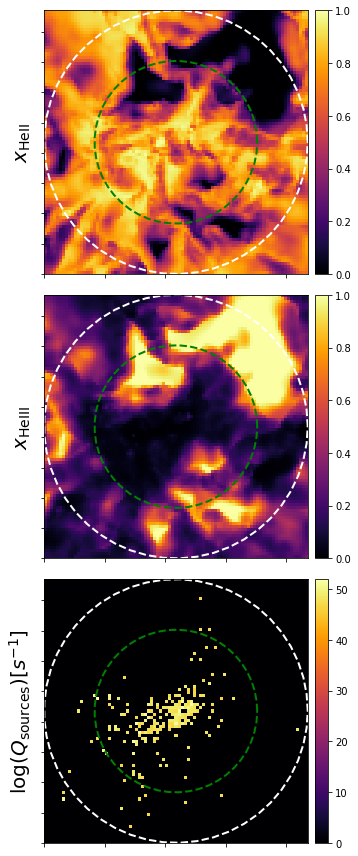

In [90]:
plot_maps(ID_1, 'esc_analysis', 8, init_props=['xHeII', 'xHeIII'], r_v = r_v_1, r_m=r_50_1, axis=0, 
          method='density_average', save=True, fesc=fesc_1, source_dens=True, source_width=None, appendix='poster2')

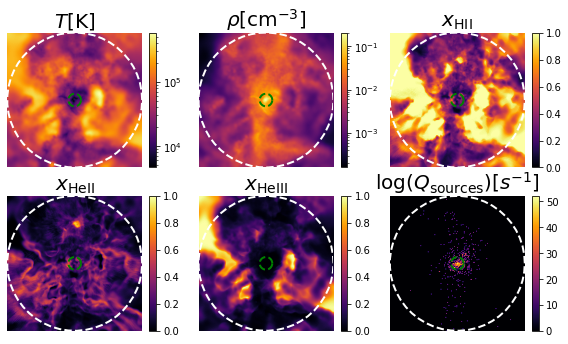

In [29]:
halo_cubehalo_cubeplot_maps(ID_1, 'fid2', 6, init_props=init_props, r_v = r_v_1, r_m=r_50_1, axis=0, 
          method='density_average', save=False, fesc=fesc_1, source_dens=True, source_width=None)

In [8]:
df.columns

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'GasMetallicity', 'FractionStars',
       'FractionGas', 'GasMassGrid', 'DustMass', 'Q0', 'HaloRadii', 'f_esc',
       'f_esc_0_2', 'Temperature', 'xHII', 'xHeII', 'xHeIII', 'GridSize',
       'BHMass', 'BHGrowth', 'SFR', 'density', 'clumping', 'per_freq',
       'per_source', 'emitted_photons', 'escaped_photons', 'frequencies',
       'n_iterations', 'per_freq_0_2', 'per_source_0_2', 'emitted_photons_0_2',
       'escaped_photons_0_2', 'frequencies_0_2', 'n_iterations_0_2',
       'clump_gas', 'sigma_gas_gal', 'sigma_star_gal', 'StellarAges'],
      dtype='object')

In [9]:
df.GridSize

0       70
1       97
2       31
3       75
4       84
        ..
8429    20
8430    42
8431    61
8432    50
8433    45
Name: GridSize, Length: 8434, dtype: int64

In [14]:
df['cell_size'] = 2*df['HaloRadii']/(df['GridSize']*(df['z']+1)*0.6774)*1000

In [15]:
df['cell_size'].describe()

count    8434.000000
mean      212.740054
std        59.573437
min        82.850823
25%       167.631949
50%       206.266079
75%       251.004035
max       889.137186
Name: cell_size, dtype: float64

In [17]:
df[(df.ID==47)&(df.z==8)].cell_size

5982    168.052007
Name: cell_size, dtype: float64

In [26]:
len(df.SFR)

8434

(0.0001, 2)

(1e+48, 2e+53)

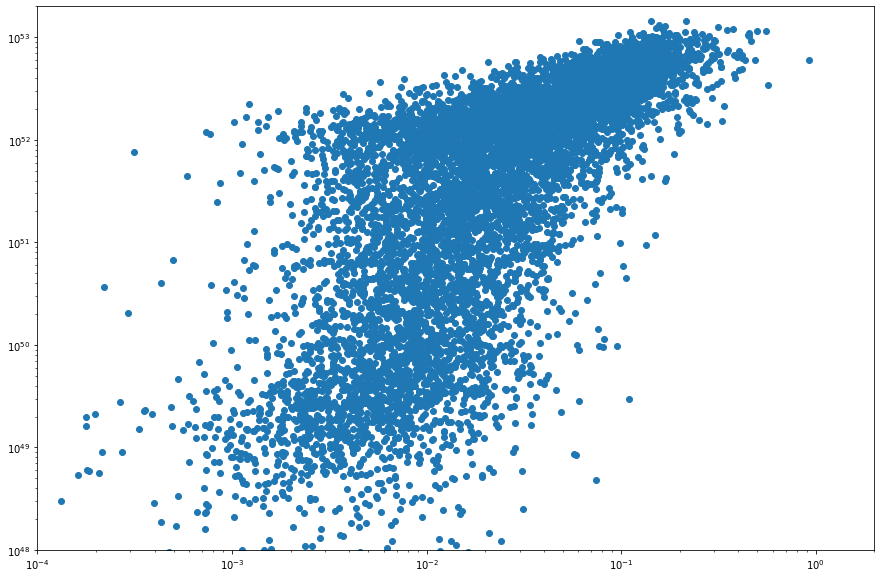

In [34]:
plt.scatter(df.SFR, df.Q0)
plt.xscale('log')
plt.xlim(1e-4,2)
plt.yscale('log')
plt.ylim(1e48,2e53)
plt.rcParams["figure.figsize"] = (15,10)